In [1]:
import os
import numpy as np
import numpyro.distributions as dist
from jax import random

import seaborn as sns
import matplotlib.pyplot as plt
# Plots
plt.style.use('seaborn-whitegrid')

# PLOT PREAMBLE: LIKE LATEX
LATEX_WIDTH = 6
LATEX_HEIGHT = 3.24

SCRIPT_SIZE = 7

#Direct input
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : SCRIPT_SIZE,
          'axes.labelsize' : SCRIPT_SIZE,
          'xtick.labelsize' : SCRIPT_SIZE,
          'ytick.labelsize' : SCRIPT_SIZE,
          'legend.fontsize' : SCRIPT_SIZE,
          'figure.titlesize' : SCRIPT_SIZE,
          'font.family' : 'serif',
          'font.serif': ['Computer Modern Roman']
          }
plt.rcParams.update(params)

## $\hat{R}$-statistics and lag-$k$-autocorrelation versus number of iterations

### Loading the data

In [2]:
from numpyro.diagnostics import gelman_rubin
from numpyro.diagnostics import autocorrelation

def R_hat_from_chains(MC_chains):
    """Computes r_hat for each iteration and dimension based on multiple chains.
    Input:
        MC_chains (np.array): shape (num_chains, num_samples, dim_data).
    Output:
        R_hat (np.array): shape (dim_data, num_samples). The first value is nan, because the diagnostic
        requires at least two samples.
    """
    num_chains, num_samples, dim_data = MC_chains.shape
    R_hat = np.zeros((dim_data, num_samples))
    R_hat[:, 0] = np.nan
    for i in range(2, num_samples):
        R_hat[:, i] = gelman_rubin(MC_chains[:, :i, :])
    return R_hat

def auto_corr_from_chain(MC_chain):
    """Computes the lag-k autocorrelation of a single MCMC chain.
    Input:
        MC_chain (np.array): shape (num_samples, dim_data)
    Output:
        auto_corr (np.array): shape (dim_data, num_samples)
    """
    autocorrs = autocorrelation(MC_chain, axis=0)
    return autocorrs.T

In [3]:
# Load the data in MC_chains: [n_chain, n_sample, datapoint]
len_chain = 500
MC_chains = {'log_normal' : np.load(f'../res/abc/diagnostics/multi_chains_laplace.npy')[:,:len_chain,:],
             'volatility_nuts_long' : np.load(f'../res/volatility/diagnostics/multi_chains_mcmc_long.npy')[:,:len_chain,:],
             'volatility_nuts_short' : np.load(f'../res/volatility/diagnostics/multi_chains_mcmc_short.npy')[:,:len_chain,:],
             'volatility_vb_full' : np.load(f'../res/volatility/diagnostics/multi_chains_vb_full.npy')[:,:len_chain,:],
             'volatility_vb_diag' : np.load(f'../res/volatility/diagnostics/multi_chains_vb_diag.npy')[:,:len_chain,:]}

# Compute R_hat
R_hat = {'log_normal' : None,
         'volatility_nuts_long' : None,
         'volatility_nuts_short' : None,
         'volatility_vb_full' : None,
         'volatility_vb_diag' : None}
for key in R_hat.keys():
    R_hat[key] = R_hat_from_chains(MC_chains[key])

# Compute autocorrelations
auto_corr = {'log_normal' : None,
             'volatility_nuts_long' : None,
             'volatility_nuts_short' : None,
             'volatility_vb_full' : None,
             'volatility_vb_diag' : None}
for key in auto_corr.keys():
    # Pick first chain for every method
    auto_corr[key] = auto_corr_from_chain(MC_chains[key][0])

### Larger plots: every method gets their own plot

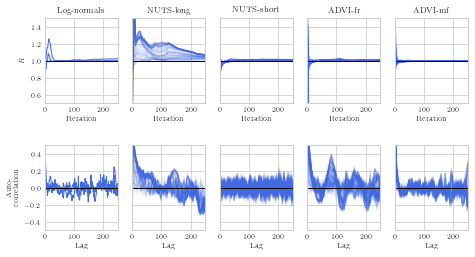

In [4]:
alpha= [1] + 4 * [.1]
linewidths = 5 * [1]
color = 'royalblue'

T = R_hat['log_normal'].shape[1]
ts = np.arange(T)

method_names = {'log_normal' : 'Log-normals',
                'volatility_nuts_long' : 'NUTS-long',
                'volatility_nuts_short' : 'NUTS-short',
                'volatility_vb_full' : 'ADVI-fr',
                'volatility_vb_diag' : 'ADVI-mf'}

methods_order = {0 : 'log_normal',
                 1 : 'volatility_nuts_long',
                 2 : 'volatility_nuts_short',
                 3 : 'volatility_vb_full',
                 4 : 'volatility_vb_diag'}


fig, axs = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(LATEX_WIDTH, .5*LATEX_WIDTH)
plt.subplots_adjust(top = .99, bottom=.01, left=.01, right=.99, hspace=.5, wspace=.2)




for j in range(5):
    method = methods_order[j]
    d = R_hat[method].shape[0]

    # R_hat
    for k in range(d):
        axs[0, j].plot(ts, R_hat[method][k, :], color=color, alpha=alpha[j], linewidth=linewidths[j])

    # Autocorrelation
    for k in range(d):
        axs[1, j].plot(ts, auto_corr[method][k, :], color=color, alpha=alpha[j], linewidth=linewidths[j])

    ## Orientation line for R_hat
    axs[0, j].axhline(1, c='k', linestyle='-', lw=1)
    # axs[0, j].axhline(1.1, c='k', linestyle='--', lw=1)
    axs[1, j].axhline(0, c='k', linestyle='-', lw=1)

    ## Axes
    axs[0, j].set_ylim([.5, 1.5])
    axs[1, j].set_ylim([-.5, .5])
    axs[0, j].set_xlim([0, 250])
    axs[1, j].set_xlim([0, 250])
    # Hide y-labels
    for i in range(2):
        if j!=0:
            axs[i, j].set_yticklabels([])
    # Hide x-labels
    # axs[0, j].set_xticklabels([])


# Annotation
for j in range(5):
    axs[0, j].set_title(method_names[methods_order[j]])
    axs[0, j].set_xlabel('Iteration')
    axs[1, j].set_xlabel('Lag')

axs[0, 0].set_ylabel(r'$\hat{R}$')
axs[1, 0].set_ylabel('Auto-\ncorrelation')

# plt.legend(framealpha=1, frameon=True, loc='lower right')
# plt.legend(framealpha=1, frameon=True)

# plt.tight_layout()
plt.savefig('../fig/monitoring.pdf', bbox_inches='tight')
plt.show()

# Test the functions with baseline random walk

In [80]:
def baseline_MC(n_chains, n_samples, dim_data, scale=2):
    MC_chains = np.zeros((n_chains, n_samples, dim_data))
    for i in range(n_chains):
        chain = np.zeros((n_samples, dim_data))
        chain[0] = np.random.multivariate_normal(mean=np.zeros(dim_data), cov=10*np.eye(dim_data))
        for j in range(1, n_samples):
            chain[j] = np.random.multivariate_normal(mean=chain[j-1]/scale, cov=np.eye(dim_data))
        MC_chains[i] = chain
    return MC_chains
# def baseline_MC(n_chains, n_samples, dim_data):
#     MC_chains = np.random.normal(loc=0, scale=1, size=(n_chains, n_samples, dim_data))
#     return MC_chains

In [69]:
len_chain = 500
MC_chains = {'log_normal' : baseline_MC(n_chains=5, n_samples=len_chain, dim_data=2),
             'volatility_nuts_long' : baseline_MC(n_chains=5, n_samples=len_chain, dim_data=100),
             'volatility_nuts_short' : baseline_MC(n_chains=5, n_samples=len_chain, dim_data=100),
             'volatility_vb_full' : baseline_MC(n_chains=5, n_samples=len_chain, dim_data=100),
             'volatility_vb_diag' : baseline_MC(n_chains=5, n_samples=len_chain, dim_data=100)}

In [70]:
# Compute R_hat
R_hat = {'log_normal' : None,
         'volatility_nuts_long' : None,
         'volatility_nuts_short' : None,
         'volatility_vb_full' : None,
         'volatility_vb_diag' : None}
for key in R_hat.keys():
    R_hat[key] = R_hat_from_chains(MC_chains[key])

# Compute autocorrelations
auto_corr = {'log_normal' : None,
             'volatility_nuts_long' : None,
             'volatility_nuts_short' : None,
             'volatility_vb_full' : None,
             'volatility_vb_diag' : None}
for key in auto_corr.keys():
    # Pick first chain for every method
    auto_corr[key] = auto_corr_from_chain(MC_chains[key][0])

In [94]:
MC_chains = baseline_MC(n_chains=5, n_samples=1000, dim_data=2, scale=2)
R_hats = R_hat_from_chains(MC_chains)
auto_corr = auto_corr_from_chain(MC_chains[0])

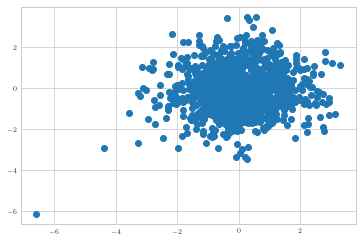

In [97]:
chain = MC_chains[0]
fig, ax = plt.subplots()
ax.scatter(chain[:, 0],chain[:, 1])
plt.show()

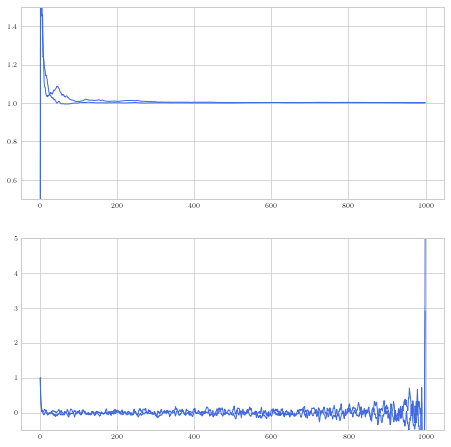

In [99]:
T = MC_chains.shape[1]
ts = np.arange(T)

fig, axs = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(LATEX_WIDTH, LATEX_WIDTH)
plt.subplots_adjust(top = .99, bottom=.01, left=.01, right=.99, hspace=.2, wspace=.2)


for k in range(2):
    axs[0].plot(ts, R_hats[k, :], color=color, alpha=1, linewidth=1)
    axs[1].plot(ts, auto_corr[k, :], color=color, alpha=1, linewidth=1)

axs[0].set_ylim((.5, 1.5))
axs[1].set_ylim((-.5, 5))
# plt.tight_layout()
# plt.savefig('../fig/monitoring.pdf', bbox_inches='tight')
plt.show()